In [17]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import cv2
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
!ls /content/drive/MyDrive/TB_Project

app  model  Notebooks  Raw  test  train  val  Visuals


In [20]:
!ls /content/drive/MyDrive/TB_Project/Raw

Normal	TB


In [21]:
# === STEP 1: Dataset Split (Raw -> train/val/test folders) ===
original_data_dir = '/content/drive/MyDrive/TB_Project/Raw'
target_base_dir = '/content/drive/MyDrive/TB_Project'
classes = ['TB', 'Normal']
train_split, val_split, test_split = 0.8, 0.1, 0.1

for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(target_base_dir, split, cls), exist_ok=True)

for cls in classes:
    img_dir = os.path.join(original_data_dir, cls)
    images = os.listdir(img_dir)
    random.shuffle(images)
    train_end = int(train_split * len(images))
    val_end = train_end + int(val_split * len(images))

    for i, img_name in enumerate(images):
        src_path = os.path.join(img_dir, img_name)
        if i < train_end:
            dst_dir = os.path.join(target_base_dir, 'train', cls)
        elif i < val_end:
            dst_dir = os.path.join(target_base_dir, 'val', cls)
        else:
            dst_dir = os.path.join(target_base_dir, 'test', cls)
        shutil.copy(src_path, os.path.join(dst_dir, img_name))

print("✅ Dataset split completed")

✅ Dataset split completed


In [22]:
# === STEP 2: Image Generators ===
img_height, img_width = 224, 224
batch_size = 32

data_gen = ImageDataGenerator(rescale=1./255)
data_gen_aug = ImageDataGenerator(rescale=1./255, zoom_range=0.2, rotation_range=10, horizontal_flip=True)

train_dir = os.path.join(target_base_dir, 'train')
val_dir = os.path.join(target_base_dir, 'val')
test_dir = os.path.join(target_base_dir, 'test')

train_generator = data_gen_aug.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='binary')
val_generator = data_gen.flow_from_directory(val_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='binary', shuffle=False)
test_generator = data_gen.flow_from_directory(test_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='binary', shuffle=False)

Found 3008 images belonging to 2 classes.
Found 1411 images belonging to 2 classes.
Found 1413 images belonging to 2 classes.


In [23]:
# === STEP 3: Model Builder Function ===
def build_model(base_model_class, name):
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output, name=name)
    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [11]:
# === STEP 4: Train & Evaluate All Models ===
model_scores = {}

def train_and_evaluate(model_name, model_class):
    model = build_model(model_class, model_name)
    save_path = f'/content/drive/MyDrive/TB_Project/model/{model_name}_best_model.h5'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    checkpoint = ModelCheckpoint(save_path, monitor='val_accuracy', save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    print(f"\n🚀 Training {model_name}...")
    history = model.fit(train_generator, epochs=5, validation_data=val_generator, callbacks=[checkpoint, early_stop])
    print(f"✅ Model saved to: {save_path}")

    print(f"\n📊 Evaluating {model_name} on test set...")
    model = load_model(save_path)
    y_true = test_generator.classes
    y_pred_prob = model.predict(test_generator)
    y_pred = (y_pred_prob > 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_prob)

    print(f"\n📊 Evaluation Metrics for {model_name}:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")

    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f'ROC Curve: {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()
    print("✅ ROC Curve plotted successfully!")

    model_scores[model_name] = roc_auc


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🚀 Training ResNet50...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7018 - loss: 0.6364
Epoch 1: val_accuracy improved from -inf to 0.83401, saving model to /content/drive/MyDrive/TB_Project/model/ResNet50_best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 677s 7s/step - accuracy: 0.7025 - loss: 0.6358 - val_accuracy: 0.8340 - val_loss: 0.4499
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8078 - loss: 0.5289
Epoch 2: val_accuracy did not improve from 0.83401
94/94 ━━━━━━━━━━━━━━━━━━━━ 634s 7s/step - accuracy: 0.8078 - loss: 0.5288 - val_accuracy: 0.8340 - val_loss: 0.4485
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8137 - loss: 0.5272
Epoch 3: val_accuracy did not improve from 0.83401
94/94 ━━━━━━━━━━━━━━━━━━━━ 573s 6s/step - accuracy: 0.8138 - loss: 0.5271 - val_accuracy: 0.8340 - val_loss: 0.4492
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8260 - loss: 0.4999
Epoch 4: val_accuracy did not improve from 0.83401
94/94 ━━━━━━━━━━━━━━━━━━━━ 567s 6s/step - accuracy: 0.8260 - loss: 0.4999 - val_accuracy: 0.8340 - val_loss: 0.4545
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8161 - loss: 0.4983
Epoch 5: val_accuracy did not improve from 0.83401
94/9

39/39 ━━━━━━━━━━━━━━━━━━━━ 225s 6s/step

📊 Evaluation Metrics for ResNet50:
Accuracy:  0.8275
Precision: 0.8275
Recall:    1.0000
F1 Score:  0.9056
ROC AUC:   0.5233


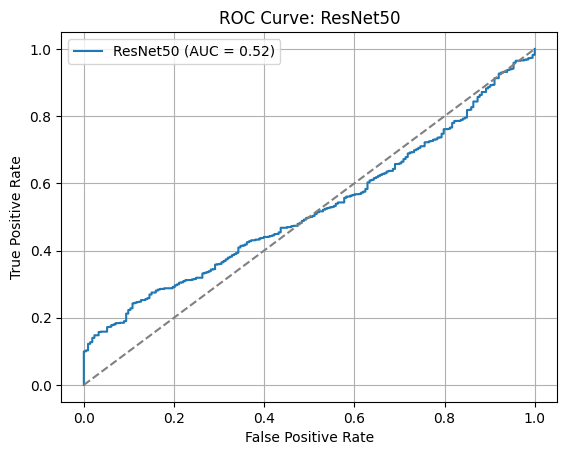

✅ ROC Curve plotted successfully!
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🚀 Training VGG16...
Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.3504 - loss: 1.1685 
Epoch 1: val_accuracy improved from -inf to 0.83401, saving model to /content/drive/MyDrive/TB_Project/model/VGG16_best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1815s 19s/step - accuracy: 0.3522 - loss: 1.1654 - val_accuracy: 0.8340 - val_loss: 0.4449
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7999 - loss: 0.4898 
Epoch 2: val_accuracy did not improve from 0.83401
94/94 ━━━━━━━━━━━━━━━━━━━━ 1728s 18s/step - accuracy: 0.8000 - loss: 0.4898 - val_accuracy: 0.8340 - val_loss: 0.4287
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8295 - loss: 0.4358 
Epoch 3: val_accuracy did not improve from 0.83401
94/94 ━━━━━━━━━━━━━━━━━━━━ 1747s 18s/step - accuracy: 0.8294 - loss: 0.4359 - val_accuracy: 0.8340 - val_loss: 0.4092
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8157 - loss: 0.4399 
Epoch 4: val_accuracy did not improve from 0.83401
94/94 ━━━━━━━━━━━━━━━━━━━━ 1763s 18s/step - accuracy: 0.8158 - loss: 0.4397 - val_accuracy: 0.8340 - val_loss: 0.3879
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.8236 - loss: 0.4084 
Epoch 5: val_accuracy did not improve f

39/39 ━━━━━━━━━━━━━━━━━━━━ 495s 13s/step

📊 Evaluation Metrics for VGG16:
Accuracy:  0.8275
Precision: 0.8275
Recall:    1.0000
F1 Score:  0.9056
ROC AUC:   0.7195


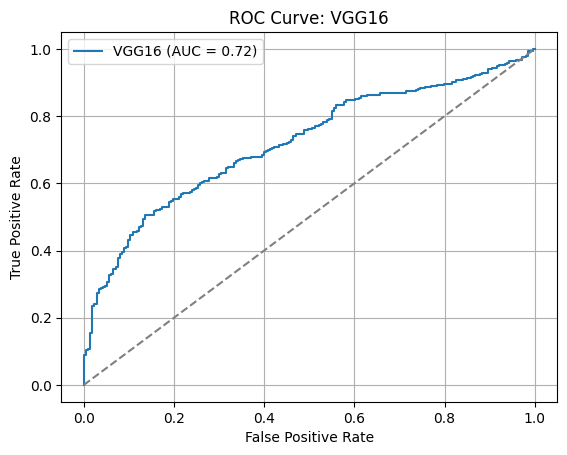

✅ ROC Curve plotted successfully!
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🚀 Training EfficientNetB0...
Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7037 - loss: 0.5651
Epoch 1: val_accuracy improved from -inf to 0.83401, saving model to /content/drive/MyDrive/TB_Project/model/EfficientNetB0_best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.7047 - loss: 0.5644 - val_accuracy: 0.8340 - val_loss: 0.4500
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8249 - loss: 0.4729
Epoch 2: val_accuracy did not improve from 0.83401
94/94 ━━━━━━━━━━━━━━━━━━━━ 238s 3s/step - accuracy: 0.8249 - loss: 0.4729 - val_accuracy: 0.8340 - val_loss: 0.4495
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8227 - loss: 0.4746
Epoch 3: val_accuracy did not improve from 0.83401
94/94 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - accuracy: 0.8227 - loss: 0.4745 - val_accuracy: 0.8340 - val_loss: 0.4526
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8199 - loss: 0.4811
Epoch 4: val_accuracy did not improve from 0.83401
94/94 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.8200 - loss: 0.4810 - val_accuracy: 0.8340 - val_loss: 0.4501
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8241 - loss: 0.4749
Epoch 5: val_accuracy did not improve from 0.83401
94/9

39/39 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step

📊 Evaluation Metrics for EfficientNetB0:
Accuracy:  0.8275
Precision: 0.8275
Recall:    1.0000
F1 Score:  0.9056
ROC AUC:   0.7184


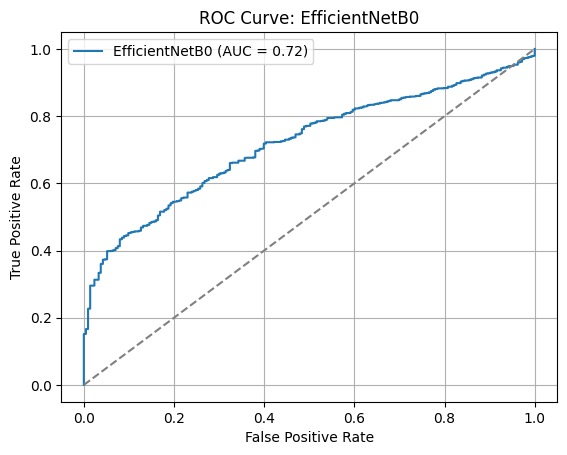

✅ ROC Curve plotted successfully!


In [12]:
# Train all 3 models
train_and_evaluate("ResNet50", ResNet50)
train_and_evaluate("VGG16", VGG16)
train_and_evaluate("EfficientNetB0", EfficientNetB0)

In [13]:
# Compare Models
print("\n🔍 Model Comparison Based on ROC-AUC:")
for model_name, score in model_scores.items():
    print(f"{model_name}: AUC = {score:.4f}")

best_model = max(model_scores, key=model_scores.get)
print(f"\n🏆 Best Performing Model: {best_model} with ROC-AUC = {model_scores[best_model]:.4f}")


🔍 Model Comparison Based on ROC-AUC:
ResNet50: AUC = 0.5233
VGG16: AUC = 0.7195
EfficientNetB0: AUC = 0.7184

🏆 Best Performing Model: VGG16 with ROC-AUC = 0.7195


In [26]:
# === STEP 4: Train & Evaluate All Models ===
model_scores = {}
from sklearn.utils import class_weight
import numpy as np

def train_and_evaluate(model_name, model_class, epochs=5):
    model = build_model(model_class, model_name)
    save_path = f'/content/drive/MyDrive/TB_Project/model/{model_name}_best_model.h5'
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    checkpoint = ModelCheckpoint(save_path, monitor='val_accuracy', save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Compute class weights for training
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_generator.classes),
        y=train_generator.classes
    )
    cw = dict(enumerate(class_weights))

    print(f"\n🚀 Training {model_name} for {epochs} epochs with class balancing...")
    history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=[checkpoint, early_stop], class_weight=cw)
    print(f"✅ Model saved to: {save_path}")

    print(f"\n📊 Evaluating {model_name} on test set...")
    model = load_model(save_path)
    y_true = test_generator.classes
    y_pred_prob = model.predict(test_generator)
    y_pred = (y_pred_prob > 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_prob)

    print(f"\n📊 Evaluation Metrics for {model_name}:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")

    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f'ROC Curve: {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()
    print("✅ ROC Curve plotted successfully!")

    model_scores[model_name] = roc_auc


🚀 Training ResNet50 for 1 epochs with class balancing...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3907 - loss: 0.9254
Epoch 1: val_accuracy improved from -inf to 0.83345, saving model to /content/drive/MyDrive/TB_Project/model/ResNet50_best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 577s 6s/step - accuracy: 0.3916 - loss: 0.9245 - val_accuracy: 0.8335 - val_loss: 0.6094
✅ Model saved to: /content/drive/MyDrive/TB_Project/model/ResNet50_best_model.h5

📊 Evaluating ResNet50 on test set...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 176s 4s/step

📊 Evaluation Metrics for ResNet50:
Accuracy:  0.8245
Precision: 0.8245
Recall:    1.0000
F1 Score:  0.9038
ROC AUC:   0.4888


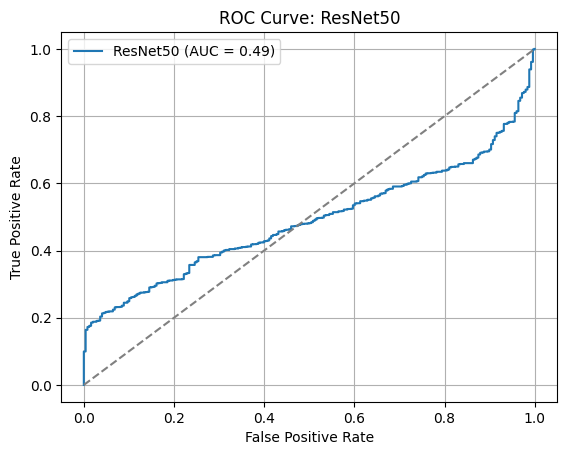

✅ ROC Curve plotted successfully!

🚀 Training VGG16 for 1 epochs with class balancing...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.4663 - loss: 0.7209 
Epoch 1: val_accuracy improved from -inf to 0.89157, saving model to /content/drive/MyDrive/TB_Project/model/VGG16_best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 1782s 19s/step - accuracy: 0.4668 - loss: 0.7207 - val_accuracy: 0.8916 - val_loss: 0.5728
✅ Model saved to: /content/drive/MyDrive/TB_Project/model/VGG16_best_model.h5

📊 Evaluating VGG16 on test set...


45/45 ━━━━━━━━━━━━━━━━━━━━ 561s 12s/step

📊 Evaluation Metrics for VGG16:
Accuracy:  0.8903
Precision: 0.9099
Recall:    0.9622
F1 Score:  0.9353
ROC AUC:   0.9379


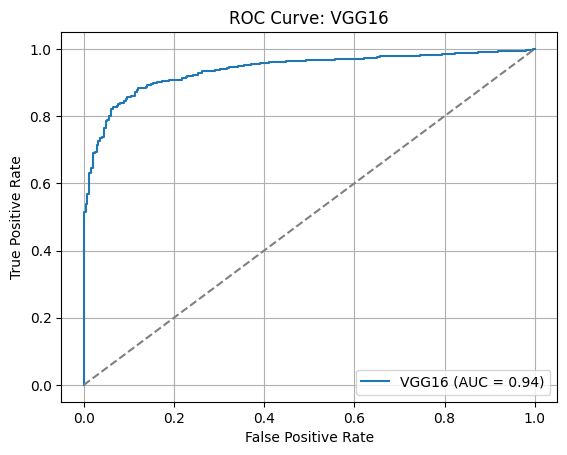

✅ ROC Curve plotted successfully!

🚀 Training EfficientNetB0 for 5 epochs with class balancing...
Epoch 1/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5366 - loss: 0.7089
Epoch 1: val_accuracy improved from -inf to 0.16655, saving model to /content/drive/MyDrive/TB_Project/model/EfficientNetB0_best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 253s 3s/step - accuracy: 0.5361 - loss: 0.7089 - val_accuracy: 0.1665 - val_loss: 0.7037
Epoch 2/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5264 - loss: 0.6971
Epoch 2: val_accuracy did not improve from 0.16655
94/94 ━━━━━━━━━━━━━━━━━━━━ 241s 3s/step - accuracy: 0.5263 - loss: 0.6971 - val_accuracy: 0.1665 - val_loss: 0.7858
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4889 - loss: 0.6968
Epoch 3: val_accuracy did not improve from 0.16655
94/94 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step - accuracy: 0.4892 - loss: 0.6969 - val_accuracy: 0.1665 - val_loss: 0.7421
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4175 - loss: 0.7083
Epoch 4: val_accuracy did not improve from 0.16655
94/94 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.4181 - loss: 0.7083 - val_accuracy: 0.1665 - val_loss: 0.7244
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4690 - loss: 0.7019
Epoch 5: val_accuracy did not improve from 0.16655
94/9

45/45 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step

📊 Evaluation Metrics for EfficientNetB0:
Accuracy:  0.1755
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000
ROC AUC:   0.3437


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


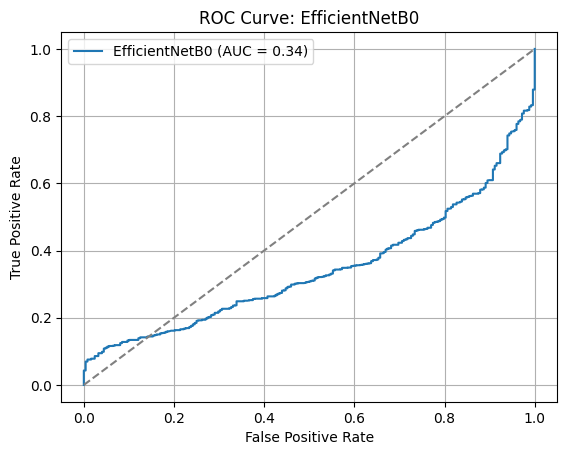

✅ ROC Curve plotted successfully!


In [27]:
# Train all 3 models (quick test setup)
train_and_evaluate("ResNet50", ResNet50, epochs=1)
train_and_evaluate("VGG16", VGG16, epochs=1)
train_and_evaluate("EfficientNetB0", EfficientNetB0, epochs=5)

In [13]:
# Compare Models
print("\n🔍 Model Comparison Based on ROC-AUC:")
for model_name, score in model_scores.items():
    print(f"{model_name}: AUC = {score:.4f}")

best_model = max(model_scores, key=model_scores.get)
print(f"\n🏆 Best Performing Model: {best_model} with ROC-AUC = {model_scores[best_model]:.4f}")